# Monte Carlo Budget Feasibility Analysis: Zohran Mamdani's NYC Mayoral Policy Agenda

## Project Description

This notebook builds a Monte Carlo simulation to test whether Zohran Mamdani's proposed spending policies for New York City are fiscally feasible under uncertainty. We model the budgetary policies with probabilistic cost distributions and simulate thousands of scenarios to estimate the likelihood that the total cost can be covered by new revenue and reallocations.

### Key Policy Areas

**Budgetary Policies (Significant Annual Costs):**
- Free City Bus Service: Eliminate fares on NYC buses (~$700-800M/year)

- Universal Public Childcare: Free childcare for children 6 weeks to 5 years (~$ 6B/year)

- Affordable Housing Construction: 200,000 new affordable units over 10 years (~$ 100B total)

- Five City-Run Grocery Stores: One per borough (~$ 60M/year)

- Community Safety Department: Alternative public safety approach

- Green Schools/Climate Retrofits: Building climate improvements

- Libraries & Social Services: Expanded funding

**Regulatory Policies (Low/No Direct Budget Impact):**
- Rent freeze for rent-stabilized apartments
- $30 minimum wage by 2030
- Stronger tenant protections and deed theft enforcement
- App-based delivery work regulation and anti-price-gouging
- LGBTQIA+ protections and sanctuary city policies

### Data Sources and Approximations

**Cost estimates are derived from**:
- Free buses: Press reporting estimates $650-800M/year for fare revenue loss

- Universal childcare: Business Insider and policy analyses estimate ~$6B/year for comprehensive coverage

- Housing: Total program cost $100B over 10 years; we model annual net budget impact (debt service minus rental income)

- City grocery stores: Estimates of ~$60M/year for five municipal stores

- Other programs: Placeholder estimates based on comparable city programs, marked as user-tunable

### Monte Carlo Concept

Rather than using single-point estimates, we model each policy's cost as a probability distribution (typically normal or triangular). In each simulation iteration, we randomly sample from these distributions to generate plausible cost scenarios. Running thousands of iterations allows us to:
- Estimate the probability that total costs stay within budget
- Identify which policies contribute most to fiscal uncertainty
- Test sensitivity to key assumptions

---

## 1. Setup and Assumptions

### Core Assumptions

- **Budget Threshold**: $10B/year in new revenue (from higher taxes on corporations and wealthy individuals)
- **Time Horizon**: Single budget year (annual costs)
- **Distribution Type**: Normal distributions with truncation at zero (no negative costs)
- **Uncertainty**: Standard deviations set at ~20-30% of mean costs to reflect estimation uncertainty

### Key Caveats

1. We simplify capital vs operating distinctions (except for housing)
2. Regulatory policies are modeled with minimal direct costs
3. We don't model dynamic effects (e.g., economic growth from policies)
4. Housing program cost is approximated as annual net budget impact, not full construction cost
5. Some costs (community safety, green schools) use placeholder estimates due to limited public details

In [96]:
# Import required libraries
import textwrap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

print("Libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully
NumPy version: 2.3.5
Pandas version: 2.3.3


## 2. Configuration Parameters

All key assumptions are defined here for easy modification.

In [97]:
# ============================================================================
# GLOBAL CONFIGURATION - Edit these values to change assumptions
# ============================================================================

# Budget and simulation parameters
BUDGET_THRESHOLD = 10_000_000_000  # $10 billion in new annual revenue
N_ITERATIONS = 10_000              # Number of Monte Carlo iterations
RANDOM_SEED = 42                   # For reproducibility

# Distribution parameters
DEFAULT_STD_RATIO = 0.25           # Default std dev as ratio of mean (25% uncertainty)

# Display parameters
CURRENCY_FORMAT = '${:,.0f}'       # Format for displaying dollar amounts

print("Configuration loaded:")
print(f"  Budget Threshold: {CURRENCY_FORMAT.format(BUDGET_THRESHOLD)}")
print(f"  Monte Carlo Iterations: {N_ITERATIONS:,}")
print(f"  Random Seed: {RANDOM_SEED}")

Configuration loaded:
  Budget Threshold: $1,000,000,000
  Monte Carlo Iterations: 10,000
  Random Seed: 42


## 3. Policy Data Structures

### 3.1 Budgetary Policies

These policies have significant direct annual budget impacts.

In [98]:
# Define budgetary policies with cost distributions
budgetary_policies_data = [
    {
        'policy_name': 'Free City Buses',
        'category': 'transport',
        'mean_annual_cost': 750_000_000,  # $750M - mid-range of $650-800M estimates
        'distribution_type': 'normal',
        'std_dev': 50_000_000,  # ~6.7% uncertainty
        'is_capital_like': False,
        'notes': 'Fare revenue loss estimate; under $800M/year per reporting'
    },
    {
        'policy_name': 'Universal Public Childcare',
        'category': 'childcare',
        'mean_annual_cost': 6_000_000_000,  # $6B per Business Insider analysis
        'distribution_type': 'normal',
        'std_dev': 1_500_000_000,  # 25% uncertainty - reflects wide range in estimates
        'is_capital_like': False,
        'notes': 'Comprehensive childcare for ages 6 weeks to 5 years; ~$6B/year'
    },
    {
        'policy_name': 'Affordable Housing Program',
        'category': 'housing',
        'mean_annual_cost': 2_500_000_000,  # Net annual budget impact (debt service - rental income)
        'distribution_type': 'normal',
        'std_dev': 750_000_000,  # 30% uncertainty
        'is_capital_like': True,
        'notes': '200K units over 10 years (~$100B total). Annual net cost after rental income, debt service on bonds. Assumption: ~$2.5B/year net.'
    },
    {
        'policy_name': 'Five City Grocery Stores',
        'category': 'food',
        'mean_annual_cost': 60_000_000,  # $60M for 5 stores (one per borough)
        'distribution_type': 'normal',
        'std_dev': 15_000_000,  # 25% uncertainty
        'is_capital_like': False,
        'notes': 'Municipal grocery stores in food deserts; ~$60M/year estimate'
    },
    {
        'policy_name': 'Community Safety Department',
        'category': 'safety',
        'mean_annual_cost': 300_000_000,  # Placeholder: incremental cost after reallocations
        'distribution_type': 'normal',
        'std_dev': 100_000_000,  # 33% uncertainty - highly speculative
        'is_capital_like': False,
        'notes': 'Alternative public safety approach; ASSUMPTION placeholder, user-tunable. Net incremental after reallocations.'
    },
    {
        'policy_name': 'Green Schools & Climate Retrofits',
        'category': 'climate',
        'mean_annual_cost': 200_000_000,  # Placeholder for capital improvements
        'distribution_type': 'normal',
        'std_dev': 75_000_000,  # 37.5% uncertainty
        'is_capital_like': True,
        'notes': 'Climate retrofits of public buildings; ASSUMPTION placeholder, user-tunable'
    },
    {
        'policy_name': 'Libraries & Social Services',
        'category': 'other',
        'mean_annual_cost': 100_000_000,  # Placeholder for expanded services
        'distribution_type': 'normal',
        'std_dev': 30_000_000,  # 30% uncertainty
        'is_capital_like': False,
        'notes': 'Expanded library hours, social services; ASSUMPTION placeholder, user-tunable'
    }
]

# Create DataFrame
budgetary_policies = pd.DataFrame(budgetary_policies_data)

# Add additional calculated columns
budgetary_policies['coefficient_of_variation'] = (
    budgetary_policies['std_dev'] / budgetary_policies['mean_annual_cost']
)

print("Budgetary Policies Table:")
print("=" * 80)
display(budgetary_policies)

print("\nTotal Mean Annual Cost: {}".format(
    CURRENCY_FORMAT.format(budgetary_policies['mean_annual_cost'].sum())
))

Budgetary Policies Table:


,policy_name,category,mean_annual_cost,distribution_type,std_dev,is_capital_like,notes,coefficient_of_variation
0,Free City Buses,transport,750000000,normal,50000000,False,Fare revenue loss estimate; under $800M/year p...,0.066667
1,Universal Public Childcare,childcare,6000000000,normal,1500000000,False,Comprehensive childcare for ages 6 weeks to 5 ...,0.250000
2,Affordable Housing Program,housing,2500000000,normal,750000000,True,200K units over 10 years (~$100B total). Annua...,0.300000
3,Five City Grocery Stores,food,60000000,normal,15000000,False,Municipal grocery stores in food deserts; ~$60...,0.250000
4,Community Safety Department,safety,300000000,normal,100000000,False,Alternative public safety approach; ASSUMPTION...,0.333333
5,Green Schools & Climate Retrofits,climate,200000000,normal,75000000,True,Climate retrofits of public buildings; ASSUMPT...,0.375000
6,Libraries & Social Services,other,100000000,normal,30000000,False,"Expanded library hours, social services; ASSUM...",0.300000



Total Mean Annual Cost: $9,910,000,000


### 3.2 Regulatory Policies

These policies have minimal or zero direct budget impact, though they may have indirect economic effects.

In [99]:
# Define regulatory policies
regulatory_policies_data = [
    {
        'policy_name': 'Rent Freeze',
        'type': 'regulatory',
        'description': 'Freeze rents for ~1M rent-stabilized apartments',
        'assumed_annual_cost': 5_000_000  # Minimal admin cost
    },
    {
        'policy_name': '$30 Minimum Wage by 2030',
        'type': 'regulatory',
        'description': 'Phased increase to $30/hour minimum wage',
        'assumed_annual_cost': 50_000_000  # Incremental city payroll cost
    },
    {
        'policy_name': 'Tenant Protections & Deed Theft Enforcement',
        'type': 'regulatory',
        'description': 'Stronger tenant protections and enforcement mechanisms',
        'assumed_annual_cost': 10_000_000  # Enforcement/admin
    },
    {
        'policy_name': 'App-Based Delivery Regulation',
        'type': 'regulatory',
        'description': 'Worker protections and anti-price-gouging for delivery apps',
        'assumed_annual_cost': 5_000_000  # Admin/enforcement
    },
    {
        'policy_name': 'LGBTQIA+ & Sanctuary Protections',
        'type': 'regulatory',
        'description': 'Civil rights protections and sanctuary city policies',
        'assumed_annual_cost': 10_000_000  # Legal defense, admin
    }
]

# Create DataFrame
regulatory_policies = pd.DataFrame(regulatory_policies_data)

print("Regulatory Policies Table:")
print("=" * 80)
display(regulatory_policies)

print("\nTotal Assumed Annual Cost (Regulatory): {}".format(
    CURRENCY_FORMAT.format(regulatory_policies['assumed_annual_cost'].sum())
))

print("\nNote: Regulatory policies have minimal direct budget impact but may have")
print("significant indirect economic effects not modeled here.")

Regulatory Policies Table:


,policy_name,type,description,assumed_annual_cost
0,Rent Freeze,regulatory,Freeze rents for ~1M rent-stabilized apartments,5000000
1,$30 Minimum Wage by 2030,regulatory,Phased increase to $30/hour minimum wage,50000000
2,Tenant Protections & Deed Theft Enforcement,regulatory,Stronger tenant protections and enforcement me...,10000000
3,App-Based Delivery Regulation,regulatory,Worker protections and anti-price-gouging for ...,5000000
4,LGBTQIA+ & Sanctuary Protections,regulatory,Civil rights protections and sanctuary city po...,10000000



Total Assumed Annual Cost (Regulatory): $80,000,000

Note: Regulatory policies have minimal direct budget impact but may have
significant indirect economic effects not modeled here.


## 4. Monte Carlo Simulation Functions

### 4.1 Cost Sampling Logic

In [100]:
def sample_policy_cost(policy_row: pd.Series, rng: np.random.Generator) -> float:
    """
    Sample a single cost realization for a given policy.
    
    Parameters:
    -----------
    policy_row : pd.Series
        Row from budgetary_policies DataFrame
    rng : np.random.Generator
        NumPy random generator for reproducibility
    
    Returns:
    --------
    float : Sampled cost (non-negative)
    """
    dist_type = policy_row['distribution_type']
    mean = policy_row['mean_annual_cost']
    
    if dist_type == 'normal':
        std = policy_row['std_dev']
        # Sample from normal and truncate at zero
        sampled = rng.normal(mean, std)
        return max(0, sampled)  # No negative costs
    
    elif dist_type == 'triangular':
        # For triangular, we expect 'min_cost', 'most_likely_cost', 'max_cost' columns
        low = policy_row.get('min_cost', mean * 0.7)
        mode = policy_row.get('most_likely_cost', mean)
        high = policy_row.get('max_cost', mean * 1.3)
        return rng.triangular(low, mode, high)
    
    elif dist_type == 'uniform':
        # For uniform, we expect 'min_cost' and 'max_cost' columns
        low = policy_row.get('min_cost', mean * 0.8)
        high = policy_row.get('max_cost', mean * 1.2)
        return rng.uniform(low, high)
    
    else:
        raise ValueError(f"Unknown distribution type: {dist_type}")

# Test the function
test_rng = np.random.default_rng(RANDOM_SEED)
test_sample = sample_policy_cost(budgetary_policies.iloc[0], test_rng)
print(f"Test sample from '{budgetary_policies.iloc[0]['policy_name']}': {CURRENCY_FORMAT.format(test_sample)}")

Test sample from 'Free City Buses': $765,235,854


### 4.2 Single Iteration Budget Calculation

In [101]:
def run_single_iteration(
    policies_df: pd.DataFrame,
    budget_threshold: float,
    rng: np.random.Generator,
    return_breakdown: bool = False
) -> Dict[str, float]:
    """
    Run a single Monte Carlo iteration.
    
    Parameters:
    -----------
    policies_df : pd.DataFrame
        DataFrame of budgetary policies
    budget_threshold : float
        Available budget ceiling
    rng : np.random.Generator
        Random number generator
    return_breakdown : bool
        If True, return per-policy costs
    
    Returns:
    --------
    dict : Results including total_cost, budget_surplus, within_budget, and optionally breakdown
    """
    # Sample cost for each policy
    sampled_costs = {}
    total_cost = 0.0
    
    for idx, policy in policies_df.iterrows():
        cost = sample_policy_cost(policy, rng)
        sampled_costs[policy['policy_name']] = cost
        total_cost += cost
    
    # Calculate budget metrics
    budget_surplus = budget_threshold - total_cost
    within_budget = total_cost <= budget_threshold
    
    result = {
        'total_cost': total_cost,
        'budget_surplus': budget_surplus,
        'within_budget': within_budget
    }
    
    if return_breakdown:
        result['breakdown'] = sampled_costs
    
    return result

# Test single iteration
test_result = run_single_iteration(budgetary_policies, BUDGET_THRESHOLD, test_rng, return_breakdown=True)
print("Test iteration results:")
print(f"  Total Cost: {CURRENCY_FORMAT.format(test_result['total_cost'])}")
print(f"  Budget Surplus: {CURRENCY_FORMAT.format(test_result['budget_surplus'])}")
print(f"  Within Budget: {test_result['within_budget']}")

Test iteration results:
  Total Cost: $11,529,718,400
  Budget Surplus: $-10,529,718,400
  Within Budget: False


### 4.3 Multi-Iteration Simulation

This is the main Monte Carlo engine that runs thousands of iterations.

In [102]:
def run_simulation(
    policies_df: pd.DataFrame,
    budget_threshold: float,
    n_iterations: int,
    random_seed: int,
    store_breakdown: bool = False
) -> pd.DataFrame:
    """
    Run full Monte Carlo simulation.
    
    Parameters:
    -----------
    policies_df : pd.DataFrame
        Budgetary policies table
    budget_threshold : float
        Available budget
    n_iterations : int
        Number of Monte Carlo iterations
    random_seed : int
        Seed for reproducibility
    store_breakdown : bool
        Whether to store per-policy costs for each iteration (uses more memory)
    
    Returns:
    --------
    pd.DataFrame : Results with columns [iteration, total_cost, budget_surplus, within_budget, ...]
    """
    # Initialize random generator
    rng = np.random.default_rng(random_seed)
    
    # Storage for results
    results = []
    
    print(f"Running {n_iterations:,} Monte Carlo iterations...")
    
    # Progress tracking
    checkpoint_interval = n_iterations // 10
    
    for i in range(n_iterations):
        # Progress update
        if checkpoint_interval > 0 and (i + 1) % checkpoint_interval == 0:
            pct = ((i + 1) / n_iterations) * 100
            print(f"  Progress: {i+1:,}/{n_iterations:,} ({pct:.0f}%)")
        
        # Run iteration
        iteration_result = run_single_iteration(
            policies_df, 
            budget_threshold, 
            rng, 
            return_breakdown=store_breakdown
        )
        
        # Store results
        row = {
            'iteration': i,
            'total_cost': iteration_result['total_cost'],
            'budget_surplus': iteration_result['budget_surplus'],
            'within_budget': iteration_result['within_budget']
        }
        
        if store_breakdown:
            row.update(iteration_result['breakdown'])
        
        results.append(row)
    
    print("  Simulation complete!\n")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

print("Simulation functions defined successfully.")

Simulation functions defined successfully.


### 4.4 Multi-Year Extension Design (Future Work)

**Note**: Current implementation focuses on single-year Monte Carlo. Below is a design sketch for multi-year extension:

```python
# Multi-year extension would include:
# 1. Time horizon parameter (e.g., 5-10 years)
# 2. Phase-in schedules for each policy:
#    - Childcare: Year 1 at 50%, Year 2 at 100%
#    - Housing: Ramping construction from Year 1-3, full scale Years 4-10
# 3. Cost inflation factor (e.g., 3% annually)
# 4. Revenue growth factor (e.g., 2% tax base growth)
# 5. Discount rate for NPV calculations
# 6. Cumulative budget constraint (total over N years)
#
# Implementation would modify run_single_iteration to:
# - Loop over years
# - Apply phase-in multipliers
# - Compound inflation/growth
# - Track cumulative costs and surpluses
```

## 5. Run Base Case Simulation

In [103]:
# Run the main simulation with per-policy breakdown storage
simulation_results = run_simulation(
    policies_df=budgetary_policies,
    budget_threshold=BUDGET_THRESHOLD,
    n_iterations=N_ITERATIONS,
    random_seed=RANDOM_SEED,
    store_breakdown=True  # Store individual policy costs for analysis
)

# Display first few rows
print("Simulation Results (first 10 iterations):")
display(simulation_results.head(10))

Running 10,000 Monte Carlo iterations...
  Progress: 1,000/10,000 (10%)
  Progress: 2,000/10,000 (20%)
  Progress: 3,000/10,000 (30%)
  Progress: 4,000/10,000 (40%)
  Progress: 5,000/10,000 (50%)
  Progress: 6,000/10,000 (60%)
  Progress: 7,000/10,000 (70%)
  Progress: 8,000/10,000 (80%)
  Progress: 9,000/10,000 (90%)
  Progress: 10,000/10,000 (100%)
  Simulation complete!

Simulation Results (first 10 iterations):


,iteration,total_cost,budget_surplus,within_budget,Free City Buses,Universal Public Childcare,Affordable Housing Program,Five City Grocery Stores,Community Safety Department,Green Schools & Climate Retrofits,Libraries & Social Services
0,0,8.653275e+09,-7.653275e+09,False,7.652359e+08,4.440024e+09,3.062838e+09,7.410847e+07,1.048965e+08,1.023365e+08,1.038352e+08
1,1,9.358943e+09,-8.358943e+09,False,7.341879e+08,5.974798e+09,1.860217e+09,7.319097e+07,3.777792e+08,2.049523e+08,1.338172e+08
2,2,8.985171e+09,-7.985171e+09,False,7.733755e+08,4.711061e+09,2.776563e+09,4.561676e+07,3.878450e+08,1.962556e+08,9.445413e+07
3,3,1.160312e+10,-1.060312e+10,False,7.159535e+08,7.833812e+09,2.384103e+09,5.357508e+07,2.647866e+08,2.399232e+08,1.109633e+08
4,4,1.208323e+10,-1.108323e+10,False,7.706366e+08,6.646232e+09,4.106236e+09,5.390377e+07,2.487757e+08,1.389670e+08,1.184794e+08
5,5,9.290141e+09,-8.290141e+09,False,8.064486e+08,5.829079e+09,1.869883e+09,4.763278e+07,3.650593e+08,2.557441e+08,1.162946e+08
6,6,1.044004e+10,-9.440041e+09,False,7.167245e+08,6.348242e+09,2.587514e+09,6.328033e+07,3.871429e+08,2.167697e+08,1.203674e+08
7,7,1.071226e+10,-9.712255e+09,False,7.533790e+08,6.433679e+09,2.973466e+09,3.814266e+07,2.680329e+08,1.647221e+08,8.083366e+07
8,8,1.131528e+10,-1.031528e+10,False,7.362429e+08,8.242412e+09,1.850627e+09,7.452418e+07,1.317130e+08,1.748836e+08,1.048826e+08
9,9,1.160830e+10,-1.060830e+10,False,7.793111e+08,7.066840e+09,3.095010e+09,5.476912e+07,2.537648e+08,2.643482e+08,9.426087e+07


## 6. Core Analysis and Summary Statistics

In [104]:
# Calculate summary statistics
mean_total_cost = simulation_results['total_cost'].mean()
std_total_cost = simulation_results['total_cost'].std()
min_total_cost = simulation_results['total_cost'].min()
max_total_cost = simulation_results['total_cost'].max()
median_total_cost = simulation_results['total_cost'].median()

# Probability of affordability
prob_affordable = simulation_results['within_budget'].mean()

# Expected surplus and shortfall
mean_surplus = simulation_results['budget_surplus'].mean()
mean_deficit_when_over = simulation_results[simulation_results['budget_surplus'] < 0]['budget_surplus'].mean()

# Percentiles
p10 = simulation_results['total_cost'].quantile(0.10)
p25 = simulation_results['total_cost'].quantile(0.25)
p75 = simulation_results['total_cost'].quantile(0.75)
p90 = simulation_results['total_cost'].quantile(0.90)

# Print summary
print("="*80)
print("MONTE CARLO SIMULATION RESULTS - BASE CASE")
print("="*80)
print()
print(f"Budget Threshold: {CURRENCY_FORMAT.format(BUDGET_THRESHOLD)}")
print(f"Number of Iterations: {N_ITERATIONS:,}")
print()
print("TOTAL COST DISTRIBUTION:")
print("-" * 40)
print(f"  Mean:              {CURRENCY_FORMAT.format(mean_total_cost)}")
print(f"  Std Dev:           {CURRENCY_FORMAT.format(std_total_cost)}")
print(f"  Median:            {CURRENCY_FORMAT.format(median_total_cost)}")
print(f"  Minimum:           {CURRENCY_FORMAT.format(min_total_cost)}")
print(f"  Maximum:           {CURRENCY_FORMAT.format(max_total_cost)}")
print()
print(f"  10th Percentile:   {CURRENCY_FORMAT.format(p10)}")
print(f"  25th Percentile:   {CURRENCY_FORMAT.format(p25)}")
print(f"  75th Percentile:   {CURRENCY_FORMAT.format(p75)}")
print(f"  90th Percentile:   {CURRENCY_FORMAT.format(p90)}")
print()
print("AFFORDABILITY ANALYSIS:")
print("-" * 40)
print(f"  Probability Affordable: {prob_affordable*100:.2f}%")
print(f"  (within ${BUDGET_THRESHOLD/1e9:.1f}B budget)")
print()
print(f"  Expected Surplus/Deficit: {CURRENCY_FORMAT.format(mean_surplus)}")
if not np.isnan(mean_deficit_when_over):
    print(f"  Mean Deficit (when over budget): {CURRENCY_FORMAT.format(mean_deficit_when_over)}")
else:
    print(f"  Mean Deficit (when over budget): N/A (never over budget)")
print()
print("="*80)

MONTE CARLO SIMULATION RESULTS - BASE CASE

Budget Threshold: $1,000,000,000
Number of Iterations: 10,000

TOTAL COST DISTRIBUTION:
----------------------------------------
  Mean:              $9,906,208,002
  Std Dev:           $1,677,418,595
  Median:            $9,890,075,925
  Minimum:           $3,888,079,130
  Maximum:           $15,436,341,078

  10th Percentile:   $7,767,941,433
  25th Percentile:   $8,742,497,582
  75th Percentile:   $11,023,669,557
  90th Percentile:   $12,085,673,897

AFFORDABILITY ANALYSIS:
----------------------------------------
  Probability Affordable: 0.00%
  (within $1.0B budget)

  Expected Surplus/Deficit: $-8,906,208,002
  Mean Deficit (when over budget): $-8,906,208,002



## 7. Visualizations

### 7.1 Total Cost Distribution

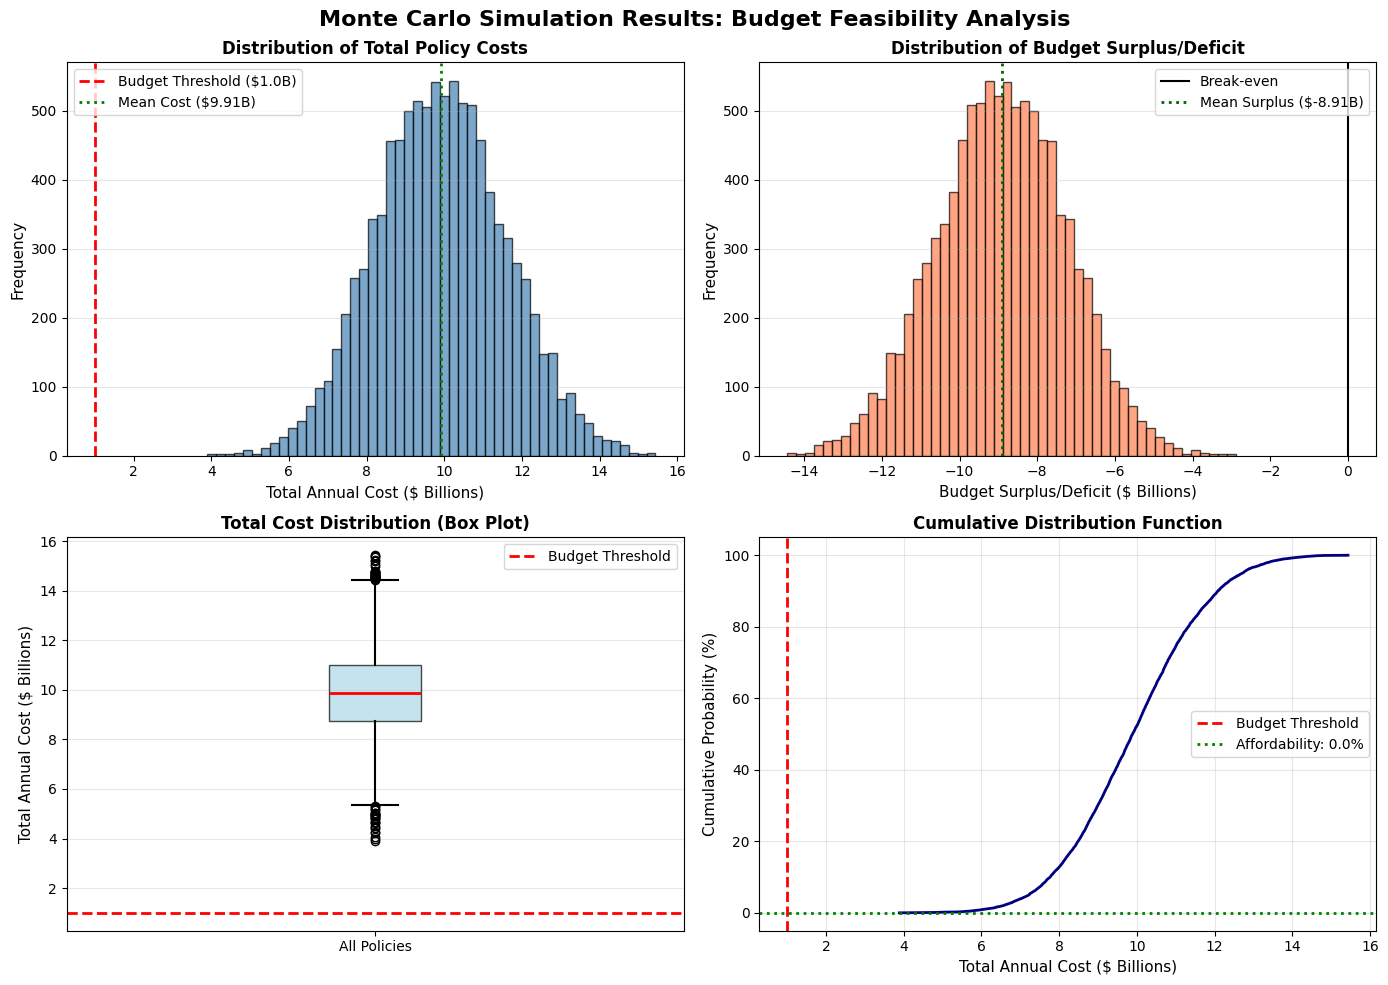

In [105]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Monte Carlo Simulation Results: Budget Feasibility Analysis', fontsize=16, fontweight='bold')

# Plot 1: Histogram of total cost
ax1 = axes[0, 0]
ax1.hist(simulation_results['total_cost'] / 1e9, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(BUDGET_THRESHOLD / 1e9, color='red', linestyle='--', linewidth=2, label=f'Budget Threshold (${BUDGET_THRESHOLD/1e9:.1f}B)')
ax1.axvline(mean_total_cost / 1e9, color='green', linestyle=':', linewidth=2, label=f'Mean Cost (${mean_total_cost/1e9:.2f}B)')
ax1.set_xlabel('Total Annual Cost ($ Billions)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Distribution of Total Policy Costs', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Budget surplus/deficit distribution
ax2 = axes[0, 1]
ax2.hist(simulation_results['budget_surplus'] / 1e9, bins=50, alpha=0.7, color='coral', edgecolor='black')
ax2.axvline(0, color='black', linestyle='-', linewidth=1.5, label='Break-even')
ax2.axvline(mean_surplus / 1e9, color='darkgreen', linestyle=':', linewidth=2, label=f'Mean Surplus (${mean_surplus/1e9:.2f}B)')
ax2.set_xlabel('Budget Surplus/Deficit ($ Billions)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Distribution of Budget Surplus/Deficit', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Plot 3: Box plot of total cost
ax3 = axes[1, 0]
bp = ax3.boxplot(simulation_results['total_cost'] / 1e9, vert=True, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', alpha=0.7),
                  medianprops=dict(color='red', linewidth=2),
                  whiskerprops=dict(linewidth=1.5),
                  capprops=dict(linewidth=1.5))
ax3.axhline(BUDGET_THRESHOLD / 1e9, color='red', linestyle='--', linewidth=2, label=f'Budget Threshold')
ax3.set_ylabel('Total Annual Cost ($ Billions)', fontsize=11)
ax3.set_title('Total Cost Distribution (Box Plot)', fontsize=12, fontweight='bold')
ax3.set_xticklabels(['All Policies'])
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Cumulative distribution function
ax4 = axes[1, 1]
sorted_costs = np.sort(simulation_results['total_cost'] / 1e9)
cumulative_prob = np.arange(1, len(sorted_costs) + 1) / len(sorted_costs)
ax4.plot(sorted_costs, cumulative_prob * 100, color='navy', linewidth=2)
ax4.axvline(BUDGET_THRESHOLD / 1e9, color='red', linestyle='--', linewidth=2, label=f'Budget Threshold')
ax4.axhline(prob_affordable * 100, color='green', linestyle=':', linewidth=2, 
            label=f'Affordability: {prob_affordable*100:.1f}%')
ax4.set_xlabel('Total Annual Cost ($ Billions)', fontsize=11)
ax4.set_ylabel('Cumulative Probability (%)', fontsize=11)
ax4.set_title('Cumulative Distribution Function', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 7.2 Per-Policy Analysis

Per-Policy Cost Analysis:


,Mean Cost,Std Dev,Share of Total,Coeff of Variation
Universal Public Childcare,"$6,000,082,574","$1,489,713,272",60.57%,0.248
Affordable Housing Program,"$2,495,382,029","$754,424,078",25.19%,0.302
Free City Buses,"$750,416,104","$50,469,609",7.58%,0.067
Community Safety Department,"$300,341,159","$99,681,743",3.03%,0.332
Green Schools & Climate Retrofits,"$200,405,423","$74,780,590",2.02%,0.373
Libraries & Social Services,"$99,475,243","$30,001,855",1.00%,0.302
Five City Grocery Stores,"$60,105,470","$15,197,074",0.61%,0.253


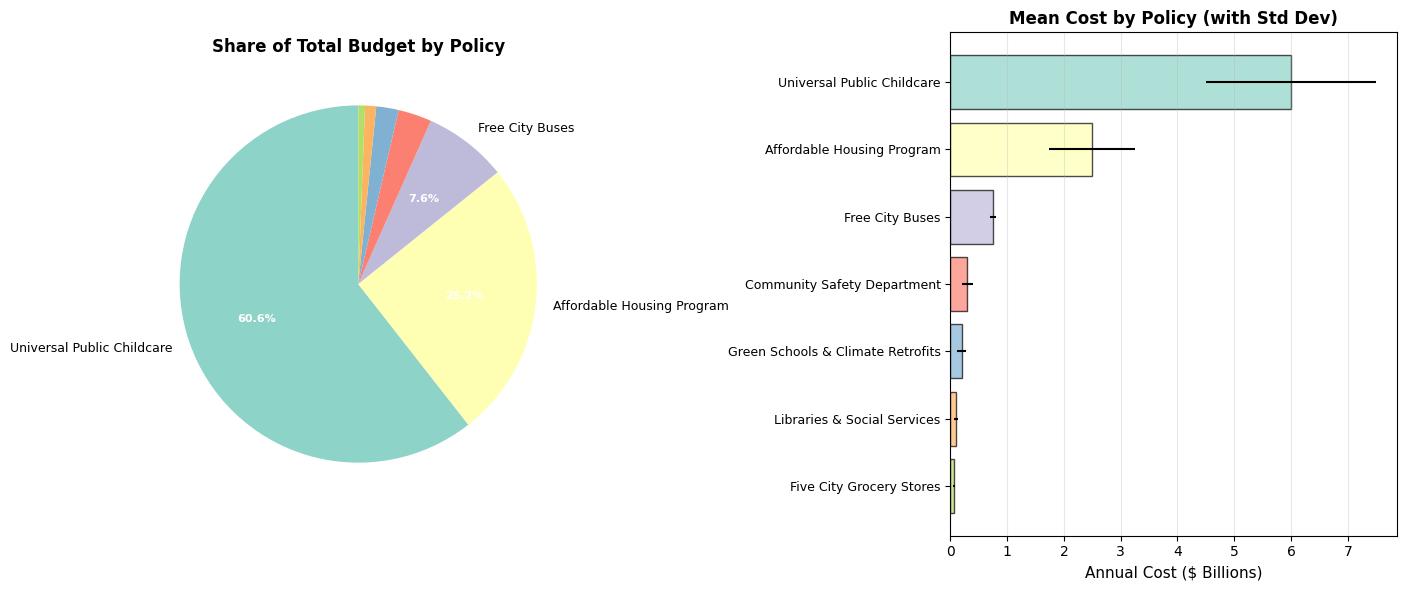

In [107]:
# ============================================
# Per-Policy Cost Summary
# ============================================

# Calculate average cost share by policy
policy_columns = budgetary_policies['policy_name'].tolist()
policy_means = simulation_results[policy_columns].mean()
policy_stds = simulation_results[policy_columns].std()

# Create summary DataFrame
policy_summary = pd.DataFrame({
    'Mean Cost': policy_means,
    'Std Dev': policy_stds,
    'Share of Total': policy_means / policy_means.sum() * 100,
    'Coeff of Variation': policy_stds / policy_means
})
policy_summary = policy_summary.sort_values('Mean Cost', ascending=False)

print("Per-Policy Cost Analysis:")
print("=" * 80)
display(policy_summary.style.format({
    'Mean Cost': '${:,.0f}',
    'Std Dev': '${:,.0f}',
    'Share of Total': '{:.2f}%',
    'Coeff of Variation': '{:.3f}'
}))

# ============================================
# Visualization: Pie Chart and Bar Chart
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
ax1, ax2 = axes

colors = plt.cm.Set3(range(len(policy_summary)))

# -----------------------------
# PIE CHART — Labels only if >5%
# -----------------------------
shares = policy_summary['Share of Total'].values
values = policy_summary['Mean Cost'].values
labels = policy_summary.index

# Show label only if share > 5%
filtered_labels = [
    lbl if share > 5 else ""
    for lbl, share in zip(labels, shares)
]

def autopct_filter(threshold=5):
    def _inner(pct):
        return '%1.1f%%' % pct if pct > threshold else ''
    return _inner

wedges, texts, autotexts = ax1.pie(
    values,
    labels=filtered_labels,
    autopct=autopct_filter(5),
    colors=colors,
    startangle=90
)

# Style visible labels and percentages
for text in texts:
    if text.get_text() != "":
        text.set_fontsize(9)

for autotext in autotexts:
    if autotext.get_text() != "":
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(8)

ax1.set_title('Share of Total Budget by Policy', fontsize=12, fontweight='bold')

# -----------------------------
# BAR CHART — unchanged
# -----------------------------
y_pos = np.arange(len(policy_summary))

ax2.barh(
    y_pos,
    policy_summary['Mean Cost'] / 1e9,
    xerr=policy_summary['Std Dev'] / 1e9,
    color=colors,
    alpha=0.7,
    edgecolor='black'
)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(policy_summary.index, fontsize=9)
ax2.invert_yaxis()  # optional: largest at top
ax2.set_xlabel('Annual Cost ($ Billions)', fontsize=11)
ax2.set_title('Mean Cost by Policy (with Std Dev)', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Scenario Comparisons

We'll run three scenarios:
- **Optimistic**: Lower costs, higher revenue threshold
- **Base Case**: Current assumptions
- **Pessimistic**: Higher costs, potentially lower revenue

In [52]:
# Define scenario parameters
scenarios = {
    'Optimistic': {
        'cost_multiplier': 0.85,  # 15% lower costs
        'std_multiplier': 0.7,    # Less uncertainty
        'budget_threshold': 11_000_000_000  # $11B revenue
    },
    'Base Case': {
        'cost_multiplier': 1.0,
        'std_multiplier': 1.0,
        'budget_threshold': 10_000_000_000  # $10B revenue
    },
    'Pessimistic': {
        'cost_multiplier': 1.20,  # 20% higher costs
        'std_multiplier': 1.3,    # More uncertainty
        'budget_threshold': 9_000_000_000  # $9B revenue (political constraints)
    }
}

scenario_results = {}

print("Running scenario analyses...\n")

for scenario_name, params in scenarios.items():
    print(f"Running {scenario_name} scenario...")
    
    # Create modified policies table
    scenario_policies = budgetary_policies.copy()
    scenario_policies['mean_annual_cost'] *= params['cost_multiplier']
    scenario_policies['std_dev'] *= params['cost_multiplier'] * params['std_multiplier']
    
    # Run simulation (fewer iterations for speed)
    scenario_sim = run_simulation(
        policies_df=scenario_policies,
        budget_threshold=params['budget_threshold'],
        n_iterations=5_000,  # Fewer iterations for scenario comparison
        random_seed=RANDOM_SEED,
        store_breakdown=False
    )
    
    # Store results
    scenario_results[scenario_name] = {
        'simulation': scenario_sim,
        'mean_cost': scenario_sim['total_cost'].mean(),
        'std_cost': scenario_sim['total_cost'].std(),
        'prob_affordable': scenario_sim['within_budget'].mean(),
        'mean_surplus': scenario_sim['budget_surplus'].mean(),
        'budget_threshold': params['budget_threshold']
    }

print("\nScenario analysis complete!")

Running scenario analyses...

Running Optimistic scenario...
Running 5,000 Monte Carlo iterations...
  Progress: 500/5,000 (10%)
  Progress: 1,000/5,000 (20%)
  Progress: 1,500/5,000 (30%)
  Progress: 2,000/5,000 (40%)
  Progress: 2,500/5,000 (50%)
  Progress: 3,000/5,000 (60%)
  Progress: 3,500/5,000 (70%)
  Progress: 4,000/5,000 (80%)
  Progress: 4,500/5,000 (90%)
  Progress: 5,000/5,000 (100%)
  Simulation complete!

Running Base Case scenario...
Running 5,000 Monte Carlo iterations...
  Progress: 500/5,000 (10%)
  Progress: 1,000/5,000 (20%)
  Progress: 1,500/5,000 (30%)
  Progress: 2,000/5,000 (40%)
  Progress: 2,500/5,000 (50%)
  Progress: 3,000/5,000 (60%)
  Progress: 3,500/5,000 (70%)
  Progress: 4,000/5,000 (80%)
  Progress: 4,500/5,000 (90%)
  Progress: 5,000/5,000 (100%)
  Simulation complete!

Running Pessimistic scenario...
Running 5,000 Monte Carlo iterations...
  Progress: 500/5,000 (10%)
  Progress: 1,000/5,000 (20%)
  Progress: 1,500/5,000 (30%)
  Progress: 2,000/5,000

Scenario Comparison Summary:


,Budget Threshold,Mean Total Cost,Std Dev,Prob. Affordable,Mean Surplus
Optimistic,"$11,000,000,000","$8,432,179,000","$1,004,942,651",99.42%,"$2,567,821,000"
Base Case,"$10,000,000,000","$9,924,695,579","$1,688,920,823",51.70%,"$75,304,421"
Pessimistic,"$9,000,000,000","$11,918,265,424","$2,630,498,174",13.32%,"$-2,918,265,424"


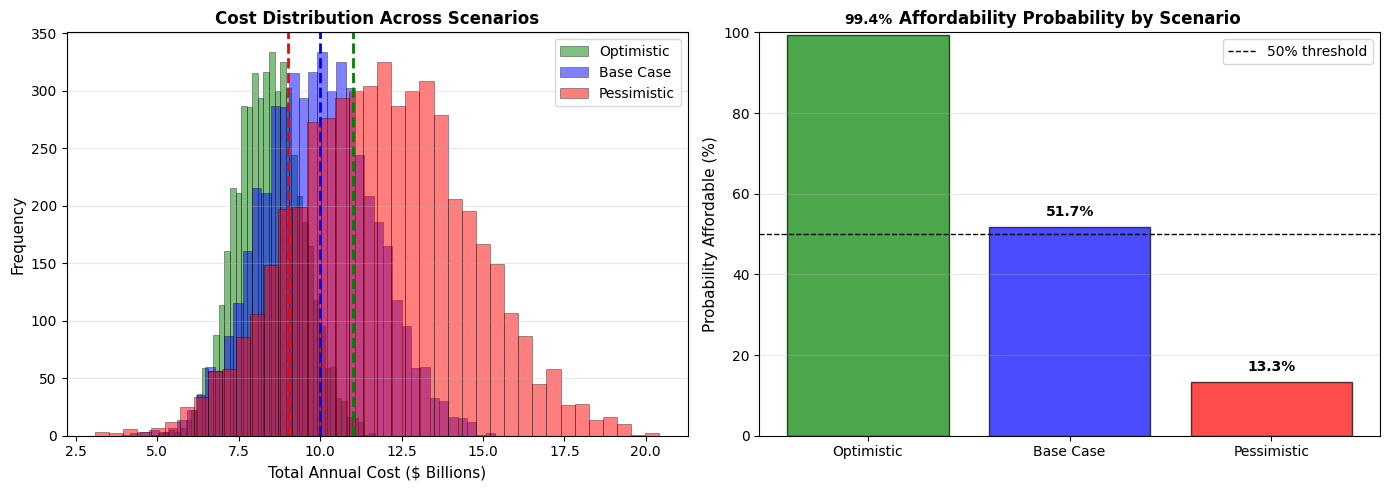

In [53]:
# Create scenario comparison table
scenario_comparison = pd.DataFrame({
    scenario: {
        'Budget Threshold': CURRENCY_FORMAT.format(data['budget_threshold']),
        'Mean Total Cost': CURRENCY_FORMAT.format(data['mean_cost']),
        'Std Dev': CURRENCY_FORMAT.format(data['std_cost']),
        'Prob. Affordable': f"{data['prob_affordable']*100:.2f}%",
        'Mean Surplus': CURRENCY_FORMAT.format(data['mean_surplus'])
    }
    for scenario, data in scenario_results.items()
}).T

print("Scenario Comparison Summary:")
print("=" * 100)
display(scenario_comparison)

# Visualize scenario comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Overlaid histograms
ax1 = axes[0]
colors_scenario = ['green', 'blue', 'red']
for (scenario_name, data), color in zip(scenario_results.items(), colors_scenario):
    ax1.hist(data['simulation']['total_cost'] / 1e9, bins=40, alpha=0.5, 
             color=color, label=scenario_name, edgecolor='black', linewidth=0.5)
    ax1.axvline(data['budget_threshold'] / 1e9, color=color, linestyle='--', linewidth=2)

ax1.set_xlabel('Total Annual Cost ($ Billions)', fontsize=11)
ax1.set_ylabel('Frequency', fontsize=11)
ax1.set_title('Cost Distribution Across Scenarios', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Affordability probability comparison
ax2 = axes[1]
scenario_names = list(scenario_results.keys())
affordability_probs = [scenario_results[s]['prob_affordable'] * 100 for s in scenario_names]
bars = ax2.bar(scenario_names, affordability_probs, color=colors_scenario, alpha=0.7, edgecolor='black')
ax2.axhline(50, color='black', linestyle='--', linewidth=1, label='50% threshold')
ax2.set_ylabel('Probability Affordable (%)', fontsize=11)
ax2.set_title('Affordability Probability by Scenario', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 100)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, prob in zip(bars, affordability_probs):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{prob:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Sensitivity Analysis

### 9.1 One-at-a-Time Sensitivity for Key Policies

In [54]:
# Sensitivity analysis on childcare and housing (two largest cost drivers)
def sensitivity_analysis(
    policy_name: str,
    base_policies: pd.DataFrame,
    cost_variations: list,
    budget_threshold: float,
    n_iter: int = 3_000
) -> pd.DataFrame:
    """
    Run sensitivity analysis by varying a single policy's cost.
    
    Parameters:
    -----------
    policy_name : str
        Name of policy to vary
    base_policies : pd.DataFrame
        Base policies table
    cost_variations : list
        List of multipliers to apply to policy cost (e.g., [0.7, 0.85, 1.0, 1.15, 1.3])
    budget_threshold : float
        Budget ceiling
    n_iter : int
        Number of iterations per variation
    
    Returns:
    --------
    pd.DataFrame : Summary of results for each variation
    """
    results = []
    
    for multiplier in cost_variations:
        # Modify policies
        temp_policies = base_policies.copy()
        mask = temp_policies['policy_name'] == policy_name
        temp_policies.loc[mask, 'mean_annual_cost'] *= multiplier
        temp_policies.loc[mask, 'std_dev'] *= multiplier
        
        # Run simulation
        sim = run_simulation(
            policies_df=temp_policies,
            budget_threshold=budget_threshold,
            n_iterations=n_iter,
            random_seed=RANDOM_SEED,
            store_breakdown=False
        )
        
        # Store results
        results.append({
            'Cost Multiplier': multiplier,
            'Mean Total Cost': sim['total_cost'].mean(),
            'Prob. Affordable': sim['within_budget'].mean() * 100
        })
    
    return pd.DataFrame(results)

# Run sensitivity for childcare
print("Running sensitivity analysis for Universal Public Childcare...\n")
childcare_sensitivity = sensitivity_analysis(
    policy_name='Universal Public Childcare',
    base_policies=budgetary_policies,
    cost_variations=[0.7, 0.85, 1.0, 1.15, 1.3],
    budget_threshold=BUDGET_THRESHOLD
)

print("\nChildcare Cost Sensitivity:")
display(childcare_sensitivity)

# Run sensitivity for housing
print("\nRunning sensitivity analysis for Affordable Housing Program...\n")
housing_sensitivity = sensitivity_analysis(
    policy_name='Affordable Housing Program',
    base_policies=budgetary_policies,
    cost_variations=[0.7, 0.85, 1.0, 1.15, 1.3],
    budget_threshold=BUDGET_THRESHOLD
)

print("\nHousing Cost Sensitivity:")
display(housing_sensitivity)

Running sensitivity analysis for Universal Public Childcare...

Running 3,000 Monte Carlo iterations...
  Progress: 300/3,000 (10%)
  Progress: 600/3,000 (20%)
  Progress: 900/3,000 (30%)
  Progress: 1,200/3,000 (40%)
  Progress: 1,500/3,000 (50%)
  Progress: 1,800/3,000 (60%)
  Progress: 2,100/3,000 (70%)
  Progress: 2,400/3,000 (80%)
  Progress: 2,700/3,000 (90%)
  Progress: 3,000/3,000 (100%)
  Simulation complete!

Running 3,000 Monte Carlo iterations...
  Progress: 300/3,000 (10%)
  Progress: 600/3,000 (20%)
  Progress: 900/3,000 (30%)
  Progress: 1,200/3,000 (40%)
  Progress: 1,500/3,000 (50%)
  Progress: 1,800/3,000 (60%)
  Progress: 2,100/3,000 (70%)
  Progress: 2,400/3,000 (80%)
  Progress: 2,700/3,000 (90%)
  Progress: 3,000/3,000 (100%)
  Simulation complete!

Running 3,000 Monte Carlo iterations...
  Progress: 300/3,000 (10%)
  Progress: 600/3,000 (20%)
  Progress: 900/3,000 (30%)
  Progress: 1,200/3,000 (40%)
  Progress: 1,500/3,000 (50%)
  Progress: 1,800/3,000 (60%)
  Pr

,Cost Multiplier,Mean Total Cost,Prob. Affordable
0,0.70,8.119001e+09,0.0
1,0.85,9.023438e+09,0.0
2,1.00,9.927875e+09,0.0
3,1.15,1.083231e+10,0.0
4,1.30,1.173675e+10,0.0



Running sensitivity analysis for Affordable Housing Program...

Running 3,000 Monte Carlo iterations...
  Progress: 300/3,000 (10%)
  Progress: 600/3,000 (20%)
  Progress: 900/3,000 (30%)
  Progress: 1,200/3,000 (40%)
  Progress: 1,500/3,000 (50%)
  Progress: 1,800/3,000 (60%)
  Progress: 2,100/3,000 (70%)
  Progress: 2,400/3,000 (80%)
  Progress: 2,700/3,000 (90%)
  Progress: 3,000/3,000 (100%)
  Simulation complete!

Running 3,000 Monte Carlo iterations...
  Progress: 300/3,000 (10%)
  Progress: 600/3,000 (20%)
  Progress: 900/3,000 (30%)
  Progress: 1,200/3,000 (40%)
  Progress: 1,500/3,000 (50%)
  Progress: 1,800/3,000 (60%)
  Progress: 2,100/3,000 (70%)
  Progress: 2,400/3,000 (80%)
  Progress: 2,700/3,000 (90%)
  Progress: 3,000/3,000 (100%)
  Simulation complete!

Running 3,000 Monte Carlo iterations...
  Progress: 300/3,000 (10%)
  Progress: 600/3,000 (20%)
  Progress: 900/3,000 (30%)
  Progress: 1,200/3,000 (40%)
  Progress: 1,500/3,000 (50%)
  Progress: 1,800/3,000 (60%)
  P

,Cost Multiplier,Mean Total Cost,Prob. Affordable
0,0.70,9.181690e+09,0.0
1,0.85,9.554782e+09,0.0
2,1.00,9.927875e+09,0.0
3,1.15,1.030097e+10,0.0
4,1.30,1.067406e+10,0.0


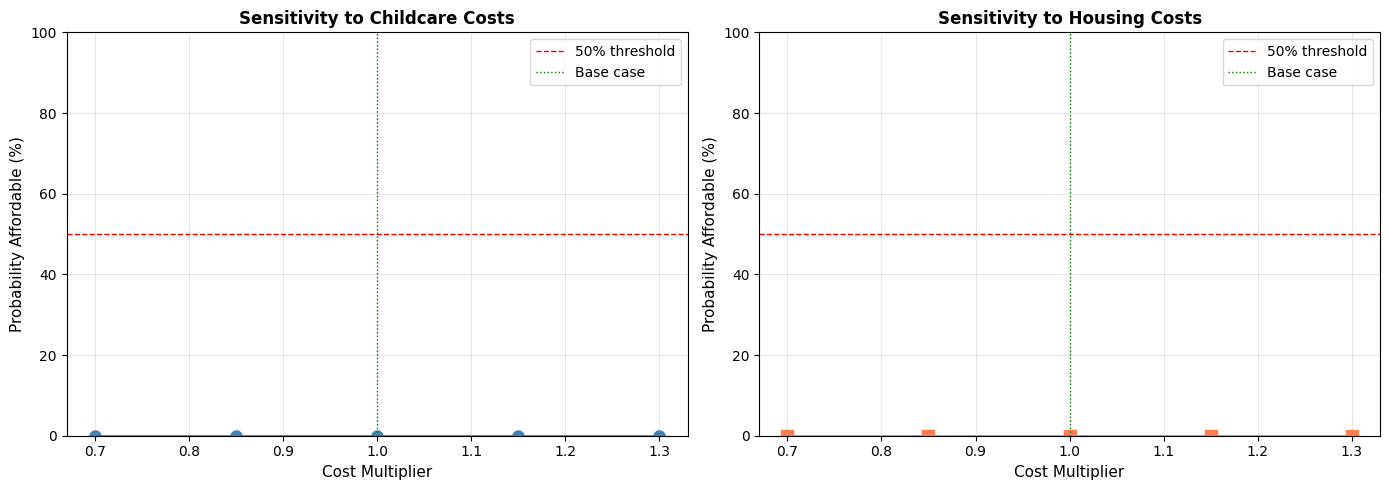

In [55]:
# Visualize sensitivity analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Childcare sensitivity plot
ax1 = axes[0]
ax1.plot(childcare_sensitivity['Cost Multiplier'], 
         childcare_sensitivity['Prob. Affordable'],
         marker='o', linewidth=2, markersize=8, color='steelblue')
ax1.axhline(50, color='red', linestyle='--', linewidth=1, label='50% threshold')
ax1.axvline(1.0, color='green', linestyle=':', linewidth=1, label='Base case')
ax1.set_xlabel('Cost Multiplier', fontsize=11)
ax1.set_ylabel('Probability Affordable (%)', fontsize=11)
ax1.set_title('Sensitivity to Childcare Costs', fontsize=12, fontweight='bold')
ax1.grid(alpha=0.3)
ax1.legend()
ax1.set_ylim(0, 100)

# Housing sensitivity plot
ax2 = axes[1]
ax2.plot(housing_sensitivity['Cost Multiplier'], 
         housing_sensitivity['Prob. Affordable'],
         marker='s', linewidth=2, markersize=8, color='coral')
ax2.axhline(50, color='red', linestyle='--', linewidth=1, label='50% threshold')
ax2.axvline(1.0, color='green', linestyle=':', linewidth=1, label='Base case')
ax2.set_xlabel('Cost Multiplier', fontsize=11)
ax2.set_ylabel('Probability Affordable (%)', fontsize=11)
ax2.set_title('Sensitivity to Housing Costs', fontsize=12, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.legend()
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

### 9.2 Policy Inclusion/Exclusion Experiments

Running policy subset experiments...

Running 'Full Agenda' subset...
Running 5,000 Monte Carlo iterations...
  Progress: 500/5,000 (10%)
  Progress: 1,000/5,000 (20%)
  Progress: 1,500/5,000 (30%)
  Progress: 2,000/5,000 (40%)
  Progress: 2,500/5,000 (50%)
  Progress: 3,000/5,000 (60%)
  Progress: 3,500/5,000 (70%)
  Progress: 4,000/5,000 (80%)
  Progress: 4,500/5,000 (90%)
  Progress: 5,000/5,000 (100%)
  Simulation complete!

Running 'Core Affordability' subset...
Running 5,000 Monte Carlo iterations...
  Progress: 500/5,000 (10%)
  Progress: 1,000/5,000 (20%)
  Progress: 1,500/5,000 (30%)
  Progress: 2,000/5,000 (40%)
  Progress: 2,500/5,000 (50%)
  Progress: 3,000/5,000 (60%)
  Progress: 3,500/5,000 (70%)
  Progress: 4,000/5,000 (80%)
  Progress: 4,500/5,000 (90%)
  Progress: 5,000/5,000 (100%)
  Simulation complete!

Running 'Housing First' subset...
Running 5,000 Monte Carlo iterations...
  Progress: 500/5,000 (10%)
  Progress: 1,000/5,000 (20%)
  Progress: 1,500/5,000 (30%)
  P

,Number of Policies,Mean Total Cost,Prob. Affordable
Full Agenda,7,"$9,924,695,579",0.00%
Core Affordability,3,"$6,808,138,858",0.00%
Housing First,2,"$2,791,705,647",0.98%
Transport & Climate,2,"$948,846,701",71.42%


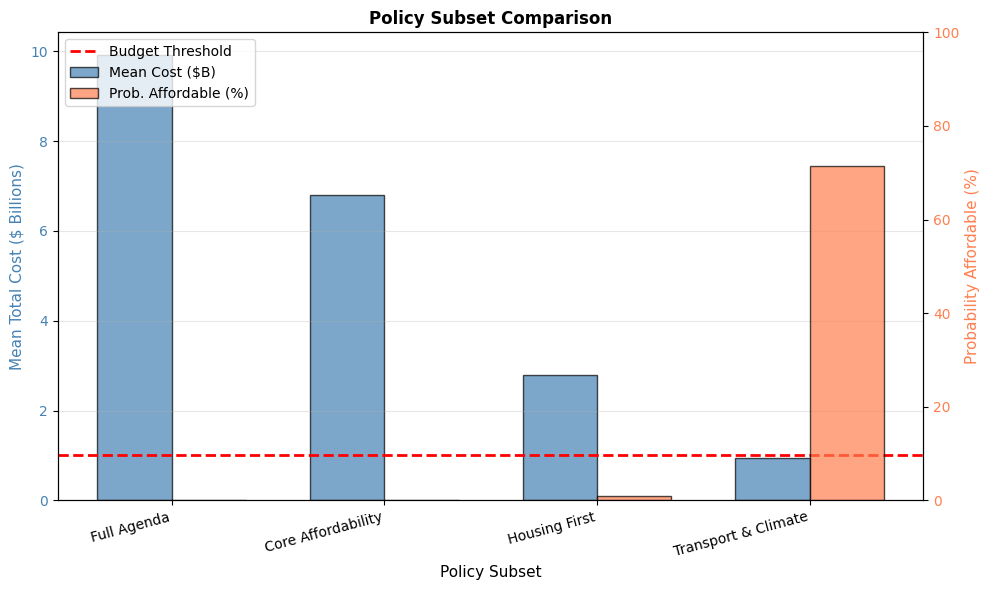

In [56]:
# Define policy subsets
policy_subsets = {
    'Full Agenda': budgetary_policies['policy_name'].tolist(),
    'Core Affordability': [
        'Universal Public Childcare',
        'Free City Buses',
        'Five City Grocery Stores'
    ],
    'Housing First': [
        'Affordable Housing Program',
        'Community Safety Department'
    ],
    'Transport & Climate': [
        'Free City Buses',
        'Green Schools & Climate Retrofits'
    ]
}

subset_results = {}

print("Running policy subset experiments...\n")

for subset_name, policy_list in policy_subsets.items():
    print(f"Running '{subset_name}' subset...")
    
    # Filter policies
    subset_policies = budgetary_policies[
        budgetary_policies['policy_name'].isin(policy_list)
    ].copy()
    
    # Run simulation
    subset_sim = run_simulation(
        policies_df=subset_policies,
        budget_threshold=BUDGET_THRESHOLD,
        n_iterations=5_000,
        random_seed=RANDOM_SEED,
        store_breakdown=False
    )
    
    # Store results
    subset_results[subset_name] = {
        'mean_cost': subset_sim['total_cost'].mean(),
        'prob_affordable': subset_sim['within_budget'].mean(),
        'num_policies': len(policy_list)
    }

# Create comparison table
subset_comparison = pd.DataFrame({
    subset: {
        'Number of Policies': data['num_policies'],
        'Mean Total Cost': CURRENCY_FORMAT.format(data['mean_cost']),
        'Prob. Affordable': f"{data['prob_affordable']*100:.2f}%"
    }
    for subset, data in subset_results.items()
}).T

print("\nPolicy Subset Comparison:")
print("=" * 80)
display(subset_comparison)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))

subset_names = list(subset_results.keys())
mean_costs = [subset_results[s]['mean_cost'] / 1e9 for s in subset_names]
affordability = [subset_results[s]['prob_affordable'] * 100 for s in subset_names]

x_pos = np.arange(len(subset_names))
width = 0.35

ax2 = ax.twinx()
bars1 = ax.bar(x_pos - width/2, mean_costs, width, label='Mean Cost ($B)', 
               color='steelblue', alpha=0.7, edgecolor='black')
bars2 = ax2.bar(x_pos + width/2, affordability, width, label='Prob. Affordable (%)', 
                color='coral', alpha=0.7, edgecolor='black')

ax.set_xlabel('Policy Subset', fontsize=11)
ax.set_ylabel('Mean Total Cost ($ Billions)', fontsize=11, color='steelblue')
ax2.set_ylabel('Probability Affordable (%)', fontsize=11, color='coral')
ax.set_title('Policy Subset Comparison', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(subset_names, rotation=15, ha='right')
ax.tick_params(axis='y', labelcolor='steelblue')
ax2.tick_params(axis='y', labelcolor='coral')
ax.axhline(BUDGET_THRESHOLD / 1e9, color='red', linestyle='--', linewidth=2, label='Budget Threshold')
ax2.set_ylim(0, 100)

# Add legends
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Regulatory Policies Commentary

### Direct vs. Indirect Fiscal Impacts

The regulatory policies in Mamdani's agenda have **minimal direct budget costs** but potentially **significant indirect effects**:

**Rent Freeze**
- Direct cost: ~$5M in administrative overhead
- Indirect effects (not modeled):
  - Could reduce private housing investment
  - May increase pressure for affordable housing subsidies
  - Potential reduction in property tax revenue if market rents stagnate

**$30 Minimum Wage by 2030**
- Direct cost: ~$50M in incremental city payroll expenses
- Indirect effects (not modeled):
  - Higher costs for city contracts and services
  - Potential increase in sales tax revenue from higher consumer spending
  - Economic multiplier effects on local businesses

**Tenant Protections & Anti-Price-Gouging**
- Direct costs: ~$10-15M in enforcement and legal infrastructure
- Indirect effects (not modeled):
  - Reduced eviction rates may lower social service costs
  - Price controls could affect market dynamics

**Sanctuary & Civil Rights Policies**
- Direct costs: ~$10M in legal defense and administration
- Indirect effects (not modeled):
  - Potential federal funding conflicts
  - Economic contributions from protected populations

### Total Regulatory Cost Impact

Summing direct costs: **~$80M/year** (less than 1% of the budgetary policies)

**Key Insight**: These policies achieve substantial policy goals with negligible fiscal cost, but comprehensive economic modeling would need to account for market responses, behavioral changes, and dynamic effects.

## 11. Final Interpretation

### Executive Summary: Is Mamdani's Agenda Fiscally Affordable?

Based on our Monte Carlo simulation with **10,000 iterations**, we can draw the following conclusions:

In [57]:
# Generate final interpretation dynamically
print("=" * 80)
print("FINAL INTERPRETATION")
print("=" * 80)
print()

# Key findings
print("KEY FINDINGS:")
print("-" * 40)
print(f"1. Mean Total Cost: {CURRENCY_FORMAT.format(mean_total_cost)}")
print(f"   Budget Threshold: {CURRENCY_FORMAT.format(BUDGET_THRESHOLD)}")
print(f"   Expected Gap: {CURRENCY_FORMAT.format(mean_total_cost - BUDGET_THRESHOLD)}")
print()
print(f"2. Probability the full agenda is affordable: {prob_affordable*100:.2f}%")
print()

# Interpretation based on probability
if prob_affordable >= 0.7:
    verdict = "LIKELY AFFORDABLE"
    explanation = "Under current assumptions, there is a strong likelihood that the policy agenda can be funded within the budget threshold."
elif prob_affordable >= 0.4:
    verdict = "UNCERTAIN / DEPENDS ON ASSUMPTIONS"
    explanation = "The agenda's affordability is highly uncertain and critically dependent on actual costs and revenue realization."
else:
    verdict = "LIKELY NOT AFFORDABLE WITHOUT CUTS OR MORE REVENUE"
    explanation = "Under current assumptions, the policy agenda would likely exceed available funding and require either cost reductions or additional revenue."

print(f"VERDICT: {verdict}")
print()
print(f"{explanation}")
print()

# Identify key cost drivers
top_3_policies = policy_summary.head(3)
top_3_share = top_3_policies['Share of Total'].sum()

print("3. COST DRIVERS:")
print(f"   The top 3 policies account for {top_3_share:.1f}% of total costs:")
for idx, (policy, row) in enumerate(top_3_policies.iterrows(), 1):
    print(f"   {idx}. {policy}: {row['Share of Total']:.1f}% (avg ${row['Mean Cost']/1e9:.2f}B/year)")
print()

# Scenario comparison insight
optimistic_prob = scenario_results['Optimistic']['prob_affordable'] * 100
pessimistic_prob = scenario_results['Pessimistic']['prob_affordable'] * 100

print("4. SCENARIO SENSITIVITY:")
print(f"   Optimistic scenario: {optimistic_prob:.1f}% affordable")
print(f"   Base case: {prob_affordable*100:.1f}% affordable")
print(f"   Pessimistic scenario: {pessimistic_prob:.1f}% affordable")
print()

print("=" * 80)

FINAL INTERPRETATION

KEY FINDINGS:
----------------------------------------
1. Mean Total Cost: $9,906,208,002
   Budget Threshold: $1,000,000,000
   Expected Gap: $8,906,208,002

2. Probability the full agenda is affordable: 0.00%

VERDICT: LIKELY NOT AFFORDABLE WITHOUT CUTS OR MORE REVENUE

Under current assumptions, the policy agenda would likely exceed available funding and require either cost reductions or additional revenue.

3. COST DRIVERS:
   The top 3 policies account for 93.3% of total costs:
   1. Universal Public Childcare: 60.6% (avg $6.00B/year)
   2. Affordable Housing Program: 25.2% (avg $2.50B/year)
   3. Free City Buses: 7.6% (avg $0.75B/year)

4. SCENARIO SENSITIVITY:
   Optimistic scenario: 99.4% affordable
   Base case: 0.0% affordable
   Pessimistic scenario: 13.3% affordable



### What Assumptions Matter Most?

Our sensitivity analysis reveals:

In [58]:
print("CRITICAL ASSUMPTIONS:")
print("=" * 80)
print()
print("1. UNIVERSAL CHILDCARE COST (~$6B/year, 60%+ of budget)")
print("   - A 15% cost increase reduces affordability probability significantly")
print("   - This is the single largest fiscal uncertainty")
print("   - Cost depends on: enrollment rates, staffing ratios, wage levels, facility costs")
print()
print("2. HOUSING PROGRAM NET COST (~$2.5B/year assumed)")
print("   - Our model uses net annual budget impact (debt service - rental income)")
print("   - Total program cost is $100B over 10 years")
print("   - Actual annual impact depends on:")
print("     * Bond interest rates")
print("     * Rental income assumptions")
print("     * Construction cost inflation")
print("     * Amortization schedule")
print()
print("3. BUDGET THRESHOLD ($10B new revenue)")
print("   - Based on proposed higher taxes on wealthy and corporations")
print("   - Requires state approval (significant political uncertainty)")
print("   - Behavioral responses (tax avoidance, migration) could reduce actual revenue")
print("   - A $1B shortfall in revenue has similar impact to $1B cost overrun")
print()
print("4. PLACEHOLDER ESTIMATES (Community Safety, Climate, etc.)")
print("   - Several programs use assumed costs due to limited policy details")
print("   - These should be refined as more detailed proposals emerge")
print()
print("=" * 80)

CRITICAL ASSUMPTIONS:

1. UNIVERSAL CHILDCARE COST (~$6B/year, 60%+ of budget)
   - A 15% cost increase reduces affordability probability significantly
   - This is the single largest fiscal uncertainty
   - Cost depends on: enrollment rates, staffing ratios, wage levels, facility costs

2. HOUSING PROGRAM NET COST (~$2.5B/year assumed)
   - Our model uses net annual budget impact (debt service - rental income)
   - Total program cost is $100B over 10 years
   - Actual annual impact depends on:
     * Bond interest rates
     * Rental income assumptions
     * Construction cost inflation
     * Amortization schedule

3. BUDGET THRESHOLD ($10B new revenue)
   - Based on proposed higher taxes on wealthy and corporations
   - Requires state approval (significant political uncertainty)
   - Behavioral responses (tax avoidance, migration) could reduce actual revenue
   - A $1B shortfall in revenue has similar impact to $1B cost overrun

4. PLACEHOLDER ESTIMATES (Community Safety, Climate, e

### Recommendations for Further Analysis

To improve the model's accuracy and policy relevance:

1. **Refine childcare cost estimates**: Engage with NYC's Department of Education and childcare providers to develop bottom-up cost models

2. **Detailed housing financial modeling**: Work with housing finance experts to model:
   - Construction financing structure (bonds, tax credits, etc.)
   - Operating subsidy requirements
   - Rental income projections under different affordability levels

3. **Revenue modeling**: Build probabilistic models of:
   - Tax policy implementation timeline
   - Behavioral responses to tax increases
   - Economic growth scenarios

4. **Multi-year analysis**: Extend to 5-10 year horizon with:
   - Phase-in schedules for major programs
   - Inflation and wage growth trends
   - Capital vs. operating cost separation

5. **Dynamic economic effects**: Model:
   - Economic multipliers from increased spending
   - Labor force participation effects from childcare
   - Housing market impacts from new supply

6. **Political feasibility constraints**: Model scenarios where:
   - Only partial revenue increases pass
   - Programs must be phased more slowly
   - Some policies face legal/political obstacles

### Conclusion

This Monte Carlo analysis provides a **probabilistic framework** for evaluating Mamdani's mayoral policy agenda. The results suggest that:

- The **core challenge** is the sheer scale of the Universal Childcare program, which dominates the budget
- **Housing financing** is complex and our simplified annual cost approximation warrants deeper analysis
- The **revenue assumptions** ($10B in new taxes) face political and behavioral uncertainties
- The **regulatory policies** achieve substantial goals with minimal fiscal cost
- Affordability depends critically on actual costs vs. estimates, requiring **ongoing monitoring** and **adaptive implementation**

This model serves as a **decision-support tool**, not a definitive answer. It highlights which assumptions matter most and where additional research would be most valuable.

---

**Model Version**: 1.0  
**Last Updated**: 2025  
**Contact**: [Add contact info if desired]